# Project:  Identify Fraud from Enron Email
-----

In [15]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Understanding the Dataset

*Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?*

> In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives.

The goal of this project will be to use publicly available data released from the Federal investigation into fraud at Enron, and use it to create a person of interest identifier.  This identifier will use email and financial data from Enron executives to try and find individuals who are persons of interest (POI).  For the purpose of this project, a POI is defined as an employee who was indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

To accomplish the goal of creating a POI identifier, I will be utilizing machine learning algorithms.  What makes machine learning useful is its ability to quickly learn from a dataset and then categorize or make predictions on data the machine has never seen before, which is exactly what we need to create our POI identifier.

### Data Exploration

Before we get started creating our POI identifier, let's examine the data.  A selection of data characteristics are listed below:

In [16]:
import pickle

enron_data = pickle.load(open("../final_project/final_project_dataset.pkl", "r"))

print 'Size of Enron Dataset:', len(enron_data)

print "Number of features for each person:", len(enron_data["SKILLING JEFFREY K"])

count = 0
for person in enron_data:
    if enron_data[person]['poi'] == 1:
        count +=1

print "Number of POI's:", count
      
print "Number of Non-POI's", len(enron_data) - count

sal_count = 0
for person in enron_data:
    if enron_data[person]['salary'] != 'NaN':
        sal_count += 1

print "People with quantifiable salaries:", sal_count

poi_sal_count = 0
for person in enron_data:
    if (enron_data[person]['salary'] != 'NaN' and enron_data[person]['poi'] == 1):
        poi_sal_count += 1

print "POI's with quantifiable salaries:", poi_sal_count
        
email_count = 0
for person in enron_data:
    if enron_data[person]['email_address'] != 'NaN':
        email_count += 1

print "People with known email addresses:", email_count

poi_email_count = 0
for person in enron_data:
    if (enron_data[person]['email_address'] != 'NaN' and enron_data[person]['poi'] == 1):
        poi_email_count += 1

print "POI's with known email addresses:", poi_email_count

tot_pay_nan_count = 0
for person in enron_data:
    if enron_data[person]['total_payments'] == 'NaN':
        tot_pay_nan_count += 1

print 'Number of people with NaN for total payments:', tot_pay_nan_count

poi_tot_pay_nan_count = 0
for person in enron_data:
    if (enron_data[person]['total_payments'] == 'NaN' and enron_data[person]['poi']):
        poi_tot_pay_nan_count += 1

print "Number of POI's with NaN for total payments:", poi_tot_pay_nan_count

Size of Enron Dataset: 146
Number of features for each person: 21
Number of POI's: 18
Number of Non-POI's 128
People with quantifiable salaries: 95
POI's with quantifiable salaries: 17
People with known email addresses: 111
POI's with known email addresses: 18
Number of people with NaN for total payments: 21
Number of POI's with NaN for total payments: 0


There are **146** data points with **21** different features (**14** financial features, **6** email features, and **1** label to indicate POI's) included for each point.  **18** of these points are POI's.

### Outlier Investigation

Next let's look to see if their are any outliers by looking at the data for salaries and bonuses.

Potential Outliers:
LAY KENNETH L
SKILLING JEFFREY K
TOTAL


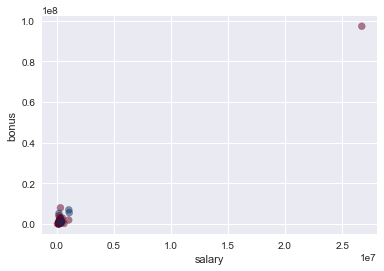

In [17]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

data_dict = pickle.load( open("../final_project/final_project_dataset.pkl", "r") )

def enron_outliers(f1, f2, total = None):
    '''Plot features from dataframe and list potential outliers for bonus and salary.'''
    
    if total == 'remove':
        #remove 'TOTAL' from dictionary
        data_dict.pop('TOTAL', 0)

    #convert data_dict to pandas df
    df = pd.DataFrame.from_records(list(data_dict.values()))
    employees = pd.Series(list(data_dict.keys()))
    df.set_index(employees, inplace=True)
    new_features_list = df.columns.values
    
    #scatterplot of salary and bonus
    plt.scatter(df[f1], df[f2], alpha = 0.5, c = df['poi'], cmap=plt.cm.RdBu)
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.show

    print "Potential Outliers:"
    for employee in data_dict:
        if (data_dict[employee]['salary'] != 'NaN') and  \
                (data_dict[employee]['bonus'] != 'NaN'):
            if (data_dict[employee]['salary'] > 1000000) and (data_dict[employee]['bonus'] > 5000000):
                print(employee)

enron_outliers('salary', 'bonus')

Looking at the above scatterplot there is one combination of salary and bonus that is significantly higher than all the others which means it could be an outlier.  To check what data points this could be let's print all executives with salary above \$1,000,000 and bonus above $5,000,000.  Of our potential outliers, the first two are **LAY KENNETH L** and **SKILLING JEFFREY K**, the former chairman and CEO of Enron respectively, as well as persons of interest, so they will left in the dataset.  However, the last potential outlier is **TOTAL** which represents the total salary and bonuses of every person in the dataset.  Since this information will not help us create our POI identifier, I removed them from the dataset.  The data without the outlier has been plotted below.

Potential Outliers:
LAY KENNETH L
SKILLING JEFFREY K


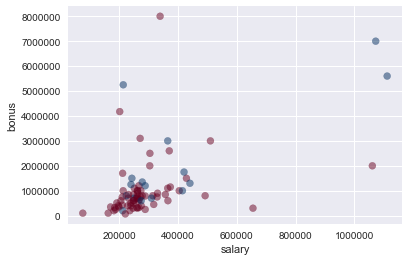

In [18]:
enron_outliers('salary', 'bonus', total = 'remove')

Next, I wanted to find and remove data points with all or nearly all missing data as well as try to find mistakes in the data.

In [19]:
#Find employees with the most missing data
for name in data_dict:
    nan_count = 0
    data_point = data_dict[name]
    for feature in data_point:
        if data_point[feature] == 'NaN':
            nan_count += 1
    if nan_count > 18:
        print name
        print data_point
    if (len(name.split()) < 2 or len(name.split()) > 4):
        print ''
        print name

LOCKHART EUGENE E
{'salary': 'NaN', 'to_messages': 'NaN', 'deferral_payments': 'NaN', 'total_payments': 'NaN', 'exercised_stock_options': 'NaN', 'bonus': 'NaN', 'restricted_stock': 'NaN', 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': 'NaN', 'total_stock_value': 'NaN', 'expenses': 'NaN', 'loan_advances': 'NaN', 'from_messages': 'NaN', 'other': 'NaN', 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'}

THE TRAVEL AGENCY IN THE PARK


In [20]:
#Remove Eugene Lockhart and THE TRAVEL AGENCY IN THE PARK from data_dict
del data_dict['LOCKHART EUGENE E']
del data_dict['THE TRAVEL AGENCY IN THE PARK']

I was able to find and remove one data point, **Eugene E. Lockhart**, that had missing data for all features except for the POI feature.  I also found an employee with the name **THE TRAVEL AGENCY IN THE PARK** which I assume has been included by mistake, so I removed that data point as well.

## Optimize Feature Selection/Engineering

*What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.*

### Engineering New Features

In addition to the existing features, I decided to create three new ones:

- **fraction_to_poi** - The proportion of a person's sent emails that were sent to a POI
- **fraction_from_poi** - The proportion of a person's receieved emails that were sent from a POI 
- **fraction_exercised_stock** - The proportion of a person's exercised stock options vs. their total stock

The idea behind creating the first two features is that POI's may email other POI's at higher rates than non-POI's.  Therefore, these features can be used to identify whether an employee shared the majority of their emails with POI's.

Similarly, the final feature was made with the intuition that POI's may have higher amounts of exercised stock options when compared to their total stock options.

In [21]:
def computeFraction( poi_messages, all_messages ):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
   """

    if (poi_messages == "NaN" or all_messages == "NaN"):
        fraction = 0
    else:
        fraction = float(poi_messages) / float(all_messages)

    return fraction

for name in data_dict:

    data_point = data_dict[name]

    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    data_point["fraction_from_poi"] = fraction_from_poi


    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    data_point["fraction_to_poi"] = fraction_to_poi
    
    
    exercised_stock_options = data_point['exercised_stock_options']
    total_stock_value = data_point['total_stock_value']
    fraction_exercised_stock = computeFraction( exercised_stock_options, total_stock_value)
    data_point['fraction_exercised_stock'] = fraction_exercised_stock

In [22]:
features_list = ['poi','salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 
                 'long_term_incentive', 'restricted_stock', 'director_fees', 'shared_receipt_with_poi', "fraction_from_poi", 
                 "fraction_to_poi", 'fraction_exercised_stock'] 

#split labels and features
data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

### Feature Selection

In order to pare down the number of features, univariate feature selection was done using sci-kit learn's *SelectKBest* algorithm.  I decided to manually choose the number of 'k' features by trying all the different values of k (e.g. k = 2, k = 3, k = 4, k = 5, ... , k = 'all') and finding the one which provided the best evaluation metrics when I ran the POI identifier.  It turns out that k = 9 and k = 10 were the best values of k to use and provided identical results.  I decided to use k = 9 to keep things simple.

In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

skb = SelectKBest(k = 9)
gnb = GaussianNB()
pipeline = Pipeline(steps = [('skb', skb), ('gnb', gnb)])
pipeline.fit(features, labels)

#indices for features chosen by SelectKBest
skb_feat_index = skb.get_support(indices = True)
#Make a dictionary of features with their scores
my_features_score = {}
for i in skb_feat_index:
    my_features_score[features_list[i + 1]] = skb.scores_[i]
#print my_features_score

my_features_list = my_features_score.keys()
my_features_list.insert(0, 'poi')
#print my_features_list

|feature|score|
|-------|-----|
|restricted_stock_deferred|24.82|
|loan_advances|24.18|
|total_payments|20.79|
|salary|18.29|
|bonus| 16.41|
|deferred_income|11.46|
|expenses|9.92|
|total_stock_value| 9.21|
|deferral_payments|8.77|

Above is a table of the 10 features given by *SelectKBest* along with their scores.  As it turns out, none of the engineered features ended up in the top 10, which I found surprising.

### Feature Scaling

Feauture scaling of the data was not necessary as PCA was not performed.  In addition, the machine learning algorithms I decided to use (Gaussian Naive Bayes and Random Forest) do not require scaling as explained by this [forum post](https://discussions.udacity.com/t/when-would-we-not-use-feature-scaling/290523/2).  To summarize, the Naive Bayes algorithm does not require feature scaling because it generates probabilities for each feature individually, assuming no correlation between any of the features.  The Decision Trees used in Random Forests also do not require feature scaling since tree splits are based on each feature and are independent of one another.

## Pick and Tune an Algorithm

*What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?*

### Pick an Algorithm

The first algorithm I decided to try was Naive Bayes and the second was a Random Forest Classifier.

In [24]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cross_validation import StratifiedShuffleSplit

data = featureFormat(data_dict, my_features_list)
labels, features = targetFeatureSplit(data)

#split training and testing folds
cv = StratifiedShuffleSplit(labels, 1000, random_state = 42)
    # outer loop, determined by the number of folds
for train_idx, test_idx in cv: 
    features_train = []
    features_test  = []
    labels_train   = []
    labels_test    = []
    # inner loop, creates the test/train data
    # once for each fold
    for ii in train_idx:
        features_train.append( features[ii] )
        labels_train.append( labels[ii] )
    for jj in test_idx:
        features_test.append( features[jj] )
        labels_test.append( labels[jj] )

gnb = GaussianNB()
gnb.fit(features_train, labels_train)

pred = gnb.predict(features_test)
accuracy = accuracy_score(pred, labels_test)
print "Naive Bayes"
print "accuracy:",accuracy
target_names = ["Non-POI", "POI"]
print "Classification Report:" 
print classification_report(y_true = labels_test, y_pred = pred, target_names = target_names)

Naive Bayes
accuracy: 0.933333333333
Classification Report:
             precision    recall  f1-score   support

    Non-POI       1.00      0.92      0.96        13
        POI       0.67      1.00      0.80         2

avg / total       0.96      0.93      0.94        15



In [25]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)
clf.fit(features_train, labels_train)

pred = clf.predict(features_test)
accuracy = accuracy_score(pred, labels_test)
print "Random Forest"
print "accuracy:",accuracy
print "Classification Report:" 
print classification_report(y_true = labels_test, y_pred = pred, target_names = target_names)

Random Forest
accuracy: 0.933333333333
Classification Report:
             precision    recall  f1-score   support

    Non-POI       0.93      1.00      0.96        13
        POI       1.00      0.50      0.67         2

avg / total       0.94      0.93      0.92        15



Comparing evaluation metrics between this classifier and Naive Bayes, the only differences were that average precision, and average f1-score were slightly higher for Naive Bayes, while accuracy and average recall was the same for both algorithms.  That said, since Naive Bayes performed the best of the two, I decided to go with this algorithm to use in the POI identifier.

### Algorithm Tuning

*What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).*

Typically, machine learning algorithms will have parameters that need to be set before they can be used.  When one says that they are tuning the parameters of an algorithm, this means that they are testing different parameter values for their algorithm with the goal of indentifying the combination of parameters that provide the optimal evaluation metric that they want to focus on (e.g. accuracy, f1-score).  What can happen if one does not tune the parameters of their algorithm well, is that the algorithm will not provide the optimal evaluation metrics.

That said, since the algorithm I chose to use, Gaussian Naive Bayes, does not have parameters I can tune, I decided to tune the Random Forest Classifier which does have parameters I can work with.  Tuning was done using *GridSearchCV* to go through multiple combinations of parameters tunes to find the optimal combination and then return a classifier using these optimal parameter tunes.  The Random Forest paremeters tuned were:

- **min_samples_split** - The minimum number of samples required to split an internal node
- **max_features** - The number of  features to consider when looking for the best split
- **criterion** - Which measure of impurity to use for the decision tree splits

In [26]:
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
parameters = {'min_samples_split':[2, 5, 10, 20],
              'max_features':('auto', 'log2'),
              'criterion':('gini', 'entropy')
             }
clf = GridSearchCV(rfc, parameters, n_jobs = -1)
clf.fit(features_train, labels_train)

pred = clf.predict(features_test)
accuracy = accuracy_score(pred, labels_test)
print "Random Forest w/ Tuning"
print "accuracy:",accuracy
print "Classification Report:" 
print classification_report(y_true = labels_test, y_pred = pred, target_names = target_names)
print "Best Parameters:",clf.best_params_

Random Forest w/ Tuning
accuracy: 0.933333333333
Classification Report:
             precision    recall  f1-score   support

    Non-POI       0.93      1.00      0.96        13
        POI       1.00      0.50      0.67         2

avg / total       0.94      0.93      0.92        15

Best Parameters: {'max_features': 'auto', 'min_samples_split': 5, 'criterion': 'entropy'}


In [27]:
from tester import dump_classifier_and_data

#dump classifier, dictionary of data, and list of features into pkl files
dump_classifier_and_data(gnb, data_dict, my_features_list)

## Validate and Evaluate

*What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?*

### Validation

Validation is the process of splitting one's data into testing and training sets, and then applying one's algorithm or model on the testing set to gauge how effective the algorithm/model is at making predictions.  A classic mistake when it comes to validation is forgetting to split the data into testing and training sets and using the same data to train and test on.  The problem this creates, is that the algorithm will overfit the data and have high variance.  In other words, this means that the algorithm will be very good at "memorizing" how to classify the the dataset given to it, and since the training and testing dataset are the same, it will appear to perform well.  However, if the algorithm is given a new dataset it has never seen before, it will perform poorly since, it is only capable of "memorizing" what to do when given the original dataset.  In short, the overfit algorithm will be unable to generalize to new data.

Cross-validation was done using *StratifiedShuffleSplit*, which splits the data into training and testing data over 1000 folds.  Using *train_test_split* to split the data into testing and training sets would have posed a problem, as there were a small number of POI's and thus there was a possibility that the POI's would be underrepresented in the training data.  That said, the main advantage of using *StratifiedShuffleSplit* in this case is that it stratified the folds so that the proportion of POI's would be the same in the training dataset as the full dataset.

### Evaluation and Conclusion

*Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance.*

Two of the evaluation metrics used to assess our algorithm's performance were **precision** and **recall**.  The precision for POI's using Naive Bayes was 0.67 and recall was 1.  What this means is that out of all the people in the dataset labelled by the algorithm as POI's, 67% of them are actually POI's.  Also, out of all the people in the dataset that were truly POI's, 100% of them were correctly labelled by the algorithm as POI's.  What this says is the algorithm was pretty "aggressive", since it found all of the POI's but 33% of all the POI's it detected were false dectections.  This could be a problem since we don't want to implicate an innocent person of fraud, however having a high recall and hence detecting the POI's in the dataset were what I wanted to focus on, so I am satisfied with the results.

Ideally, I would like to try and improve the precision for POI's, which would be difficult given the current lack of data for POI's.  Perhaps introducing text data from the email corpus could provide more information improve the performance of the POI identifier.  Using text learning could uncover possible words or phrases that appear frequently in emails written by POI's.